In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

In [94]:
INPUT_DAYS = 30 # 用多少天來作為預測資料
TRAIN_PCT = 0.85 # 切分成訓練資料的比例
PREDICTION_WINDOWS = 14 # 預測日和我們的輸入間隔幾天

In [95]:
def maeLoss(predictions, groundtruth):
    loss = 0
    for prediction, actual in zip(predictions, groundtruth):
        loss += abs(prediction-actual)
    return loss/len(predictions)

In [96]:
def showGraph(model, test_target):
    test_predictions = model.predict(test_feature).flatten()
    test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':test_target})
    print(f'Mean Absolute Error: {maeLoss(test_predictions, test_target)}')
    plt.plot(test_results['Train Predictions'])
    plt.plot(test_results['Actuals'])
    plt.show()

### Read Files and Replace Null Value

In [97]:
## 新冠資料要2020後才有，禽流感則是2015，所以可能要權衡一下是否要增加欄位而放棄資料筆數，或是有什麼方法可以彌補資料不全的部分
FILE_PREFIX = 'data/'
FILES = ['72G600_WEATHER.csv', 'EGG_PRICE.csv', 'EGG_PRODUCTION.csv', 'WEED_PRICE.csv'] # 'COVID.csv', 'AVIAN_INFLUENZA.csv'
DATAFRAMES = []

for FILE in FILES:
    df = pd.read_csv(FILE_PREFIX+FILE, encoding='utf-8', index_col=False) # 從檔案讀取
    df = df.replace('休市', np.NaN) # 當雞蛋價格為休市視為空值
    df.fillna(method='pad', inplace=True) # 用前一筆資料補齊空的資料
    DATAFRAMES.append(df)

### Merge Data from Different Files

In [98]:
df_all = DATAFRAMES[0]
for i, DATAFRAME in enumerate(DATAFRAMES):
    if i == 0: continue
    if 'date' in DATAFRAME: df_all = df_all.merge(DATAFRAME, how='inner', on=['month', 'date']) # 都是日資料的合併
    else: df_all = pd.merge(df_all, DATAFRAME, left_on="month", right_on="month") # 日資料及月資料的合併 (目前同一個月就都用一樣的數值)
df_all['egg_price'] = pd.to_numeric(df_all['egg_price'])
df_all = pd.get_dummies(df_all, columns=["lunar_date"]) # 農曆日期這邊看成categorical feature，所以用one hot encoding的方式

### Data Normalization

In [99]:
from sklearn.preprocessing import MinMaxScaler
columns = df_all.columns.to_list()
columns.remove('month') # 移除非訓練欄位的部分
columns.remove('date')
scaler = MinMaxScaler(feature_range=(0, 1)) # normalization
scaled_feature = scaler.fit_transform(df_all[columns])
target_value = df_all['egg_price'].to_numpy() # 目標欄位為蛋價
target_label = [1 if target_value[i]<target_value[i+PREDICTION_WINDOWS] else 0 for i in range(len(target_value)-PREDICTION_WINDOWS)] # 另外新增和x天後相比的標籤
target_label = np.array(target_label)

In [100]:
DATA_COUNT = len(scaled_feature)
FEATURE_COUNT = len(scaled_feature[0])
print(f'Data Count: {DATA_COUNT}\nFeature Count: {FEATURE_COUNT}')

Data Count: 4077
Feature Count: 381


### Fully Connected Nueral Network

In [101]:
train_feature = scaled_feature[0:int(DATA_COUNT*TRAIN_PCT)]
train_target = target_value[INPUT_DAYS:int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS]
test_feature = scaled_feature[int(DATA_COUNT*TRAIN_PCT):len(scaled_feature)-INPUT_DAYS]
test_target = target_value[int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS:]
train_target_label = target_label[INPUT_DAYS-PREDICTION_WINDOWS:int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS-PREDICTION_WINDOWS] # 用在如果要用classification的話
test_target_label = target_label[int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS-PREDICTION_WINDOWS:] # 用在如果要用classification的話

Epoch 1/50
217/217 [==============================] - 1s 940us/step - loss: 15.8166
Epoch 2/50
217/217 [==============================] - 0s 704us/step - loss: 3.6634
Epoch 3/50
217/217 [==============================] - 0s 639us/step - loss: 3.3469
Epoch 4/50
217/217 [==============================] - 0s 870us/step - loss: 3.0396
Epoch 5/50
217/217 [==============================] - 0s 671us/step - loss: 2.7650
Epoch 6/50
217/217 [==============================] - 0s 690us/step - loss: 2.5271
Epoch 7/50
217/217 [==============================] - 0s 713us/step - loss: 2.3639
Epoch 8/50
217/217 [==============================] - 0s 783us/step - loss: 2.2865
Epoch 9/50
217/217 [==============================] - 0s 676us/step - loss: 2.2045
Epoch 10/50
217/217 [==============================] - 0s 653us/step - loss: 2.1669
Epoch 11/50
217/217 [==============================] - 0s 694us/step - loss: 2.1350
Epoch 12/50
217/217 [==============================] - 0s 676us/step - loss: 2.1182


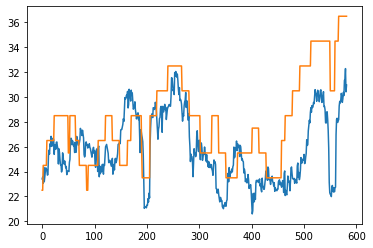

In [102]:
model = Sequential()
model.add(Dense(12, input_dim=(train_feature.shape[1]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))

## predict label ##
# model.add(Dense(2, activation='softmax'))
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_feature, train_target_label, epochs=50, batch_size=16, validation_data=(test_feature, test_target_label))

## predict actual price ##
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.fit(train_feature, train_target, epochs=50, batch_size=16)
showGraph(model, test_target)

### LSTM Model

In [103]:
feature = []
for i in range(len(scaled_feature)-INPUT_DAYS):
    feature.append(scaled_feature[i:i+INPUT_DAYS])
train_feature = np.array(feature[0:int(len(scaled_feature)*TRAIN_PCT)])
test_feature = np.array(feature[int(len(scaled_feature)*TRAIN_PCT):len(scaled_feature)-INPUT_DAYS-PREDICTION_WINDOWS])
train_target = target_value[PREDICTION_WINDOWS+INPUT_DAYS:int(DATA_COUNT*TRAIN_PCT)+PREDICTION_WINDOWS+INPUT_DAYS]
test_target = target_value[int(DATA_COUNT*TRAIN_PCT)+PREDICTION_WINDOWS+INPUT_DAYS:]
train_target_label = target_label[INPUT_DAYS:int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS] # 用在如果要用classification的話
test_target_label = target_label[int(DATA_COUNT*TRAIN_PCT)+INPUT_DAYS:] # 用在如果要用classification的話

Epoch 1/15
109/109 [==============================] - 5s 36ms/step - loss: 7.9465
Epoch 2/15
109/109 [==============================] - 4s 34ms/step - loss: 4.5892
Epoch 3/15
109/109 [==============================] - 4s 34ms/step - loss: 4.1666
Epoch 4/15
109/109 [==============================] - 4s 34ms/step - loss: 4.0407
Epoch 5/15
109/109 [==============================] - 4s 34ms/step - loss: 3.7818
Epoch 6/15
109/109 [==============================] - 4s 34ms/step - loss: 3.7032
Epoch 7/15
109/109 [==============================] - 4s 34ms/step - loss: 3.6066
Epoch 8/15
109/109 [==============================] - 4s 34ms/step - loss: 3.5468
Epoch 9/15
109/109 [==============================] - 4s 34ms/step - loss: 3.4974
Epoch 10/15
109/109 [==============================] - 4s 35ms/step - loss: 3.4448
Epoch 11/15
109/109 [==============================] - 4s 37ms/step - loss: 3.4930
Epoch 12/15
109/109 [==============================] - 4s 35ms/step - loss: 3.3414
Epoch 13/15
1

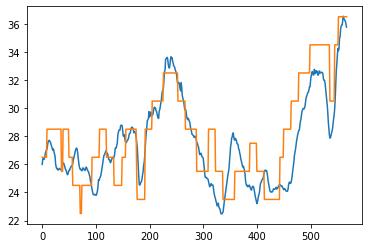

In [104]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_feature.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

## predict label ##
# model.add(Dense(2, activation='softmax'))
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_feature, train_target_label, epochs=15, validation_data=(test_feature, test_target_label))

## predict actual price ##
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
model.compile(optimizer=optimizer, loss='mae')
model.fit(train_feature, train_target, epochs=15)
showGraph(model, test_target)